In [1]:
import copy
import json
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm

from preprocessing import PreProcessing

In [68]:
from kloppy import skillcorner

dataset = skillcorner.load_open_data(
    match_id=2068,

    coordinates="metrica",
    include_empty_frames=True
).to_df()

In [69]:
dataset

,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,ball_speed,7638_x,...,away_anon_10663_d,away_anon_10663_s,away_anon_10674_x,away_anon_10674_y,away_anon_10674_d,away_anon_10674_s,away_anon_10673_x,away_anon_10673_y,away_anon_10673_d,away_anon_10673_s
0,1,0 days 00:00:00,1833,None,NaN,NaN,NaN,NaN,None,0.286359,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
1,1,0 days 00:00:00.100000,1834,None,NaN,NaN,NaN,NaN,None,0.287093,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
2,1,0 days 00:00:00.200000,1835,None,NaN,NaN,NaN,NaN,None,0.287707,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
3,1,0 days 00:00:00.300000,1836,None,NaN,NaN,NaN,NaN,None,0.288795,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
4,1,0 days 00:00:00.400000,1837,None,NaN,NaN,NaN,NaN,None,0.289064,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58943,2,0 days 00:49:54.200000,72103,None,139.0,0.936581,-0.020465,0.063876,None,NaN,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
58944,2,0 days 00:49:54.300000,72104,None,139.0,0.941653,-0.024549,0.039067,None,NaN,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
58945,2,0 days 00:49:54.400000,72105,None,139.0,0.946676,-0.028225,0.018283,None,NaN,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
58946,2,0 days 00:49:54.500000,72106,None,139.0,0.951649,-0.031491,0.001524,None,NaN,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None


In [58]:
dataset

,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,ball_speed,11591_x,...,away_anon_9616_d,away_anon_9616_s,away_anon_9622_x,away_anon_9622_y,away_anon_9622_d,away_anon_9622_s,away_anon_9626_x,away_anon_9626_y,away_anon_9626_d,away_anon_9626_s
0,1,0 days 00:00:00.700000,449,None,NaN,NaN,NaN,NaN,None,0.442219,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
1,1,0 days 00:00:00.800000,450,None,NaN,NaN,NaN,NaN,None,0.445927,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
2,1,0 days 00:00:00.900000,451,None,NaN,0.631063,0.508230,0.024569,None,0.450486,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
3,1,0 days 00:00:01,452,None,NaN,0.639941,0.513352,0.052221,None,0.455898,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
4,1,0 days 00:00:01.100000,453,None,NaN,0.648167,0.517823,0.087757,None,0.462145,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36891,2,0 days 00:49:04.900000,68311,None,NaN,NaN,NaN,NaN,None,NaN,...,None,None,NaN,NaN,None,None,0.065113,0.662576,None,None
36892,2,0 days 00:49:05,68312,None,NaN,NaN,NaN,NaN,None,NaN,...,None,None,NaN,NaN,None,None,0.064815,0.664234,None,None
36893,2,0 days 00:49:05.100000,68313,None,NaN,NaN,NaN,NaN,None,NaN,...,None,None,NaN,NaN,None,None,0.064370,0.665524,None,None
36894,2,0 days 00:49:05.200000,68314,None,NaN,NaN,NaN,NaN,None,NaN,...,None,None,NaN,NaN,None,None,0.064013,0.666736,None,None


## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [39]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [40]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [41]:
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [42]:
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


## Tracking for individual Players for the First Period

AttributeError: 'PreProcessing' object has no attribute 'colors'

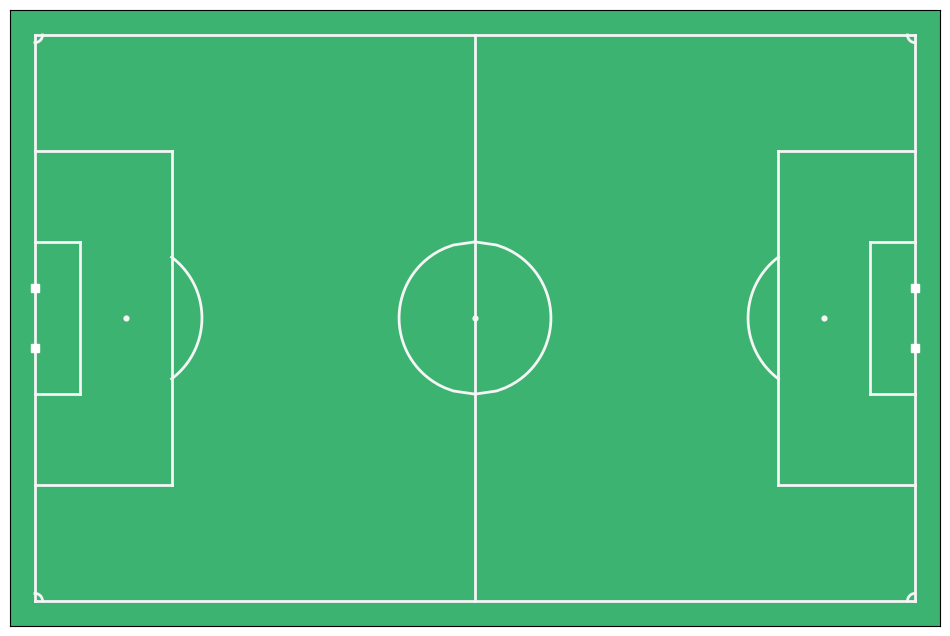

In [6]:
game_2_pre.player_tracking(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

In [ ]:
# player_tracking(period_1_data)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Adding extra features to dataset

In [43]:
vel_acc_game_1_data = game_1_pre.vel_acc(game_1_data)
vel_acc_game_2_data = game_2_pre.vel_acc(game_2_data)

In [44]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.151215,NaN
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123138,-0.701914
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.011138,0.278458,0.019121,0.478033,0.015201,0.380019,0.029611,0.740275,0.415521,-17.690434
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.008515,-0.065591,0.011560,-0.189042,0.022103,0.172568,0.029100,-0.012774,0.417319,0.044937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.010198,0.098326,0.002704,0.017604,0.013613,0.028951,0.017509,0.062515,0.000000,0.000000
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.004031,-0.154173,0.011319,0.215377,0.014346,0.018330,0.022407,0.122446,0.000000,0.000000
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.009394,0.134075,0.007906,-0.085338,0.013829,-0.012921,0.009100,-0.332665,0.000000,0.000000
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.013500,0.102646,0.013440,0.138350,0.015004,0.029371,0.007754,-0.033653,0.000000,0.000000


In [45]:
vel_acc_game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00875,0.06250,0.010000,-0.027615,0.0,0.0,0.0,0.0,0.0,0.0
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00975,0.02500,0.006951,-0.076232,0.0,0.0,0.0,0.0,0.0,0.0
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00700,-0.06875,0.016623,0.241798,0.0,0.0,0.0,0.0,0.0,0.0
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00925,0.05625,0.009014,-0.190219,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]

In [47]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00875,0.06250,0.010000,-0.027615,0.0,0.0,0.0,0.0,0.0,0.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00975,0.02500,0.006951,-0.076232,0.0,0.0,0.0,0.0,0.0,0.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00700,-0.06875,0.016623,0.241798,0.0,0.0,0.0,0.0,0.0,0.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00925,0.05625,0.009014,-0.190219,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# game_1_players, game_1_vel_acc = game_1_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_1_ply_tra.loc[:,"P_1_velocity":]
# game_2_players, game_2_vel_acc = game_2_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_2_ply_tra.loc[:,"P_1_velocity":]

In [13]:
game_1_player_data = game_1_pre.get_frames(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2]).round(2).fillna(0)
game_2_player_data = game_2_pre.get_frames(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2]).round(2).fillna(0)

In [14]:
game_2_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
1,0.94,0.50,0.0,0.0,0.65,0.29,0.0,0.0,0.68,0.43,...,0.0,0.0,0.50,0.36,0.0,0.0,0.50,0.50,0.0,0.0
2,0.94,0.50,0.0,0.0,0.65,0.29,0.0,0.0,0.68,0.43,...,0.0,0.0,0.50,0.36,0.0,0.0,0.50,0.50,0.0,0.0
3,0.94,0.50,0.0,0.0,0.65,0.29,0.0,0.0,0.68,0.43,...,0.0,0.0,0.50,0.36,0.0,0.0,0.50,0.50,0.0,0.0
4,0.94,0.50,0.0,0.0,0.65,0.29,0.0,0.0,0.68,0.43,...,0.0,0.0,0.50,0.36,0.0,0.0,0.50,0.50,0.0,0.0
5,0.94,0.50,0.0,0.0,0.65,0.29,0.0,0.0,0.68,0.43,...,0.0,0.0,0.50,0.36,0.0,0.0,0.50,0.50,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06,0.51,0.0,0.0,0.38,0.15,0.0,0.0,0.23,0.41,...,0.0,0.0,0.37,0.12,0.0,0.0,0.41,-0.04,0.0,0.0
141153,0.06,0.51,0.0,0.0,0.38,0.15,0.0,0.0,0.23,0.41,...,0.0,0.0,0.37,0.12,0.0,0.0,0.41,-0.04,0.0,0.0
141154,0.06,0.51,0.0,0.0,0.38,0.15,0.0,0.0,0.23,0.41,...,0.0,0.0,0.37,0.12,0.0,0.0,0.41,-0.04,0.0,0.0
141155,0.06,0.51,0.0,0.0,0.38,0.15,0.0,0.0,0.23,0.41,...,0.0,0.0,0.37,0.12,0.0,0.0,0.41,-0.04,0.0,0.0


# Classification

In [15]:
def change_player_name(data: pd.Series) -> pd.Series:
    result = []
    name = ""
    for i in range(len(data)):
        item = data.iloc[i]
        if len(item) == 8:
            if int(item[-2:]) < 12:
                name = f"Home-P_{item[-2:]}"
            else:
                name = f"Away-P_{item[-2:]}"
        else:
            name = f"Home-P_{item[-1:]}"
            
        result.append(name)

    return pd.Series(data=result, name=data.name)

In [48]:
game_1_event_data = pd.read_csv("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv")
game_2_event_data = pd.read_csv("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv")

In [49]:
game_1_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,0.60,0.33,0.19,0.95
1741,Home,PASS,NaN,2,143578,5743.12,143593,5743.72,Player13,Player4,0.09,0.88,0.14,0.69
1742,Home,BALL LOST,INTERCEPTION,2,143598,5743.92,143618,5744.72,Player4,NaN,0.13,0.69,0.07,0.61
1743,Away,RECOVERY,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,0.05,0.62,NaN,NaN


In [50]:
game_2_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,0.54,0.77,0.29,0.24
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,0.31,0.30,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,0.32,0.30,NaN,NaN
1933,Home,RECOVERY,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,0.34,0.32,NaN,NaN


In [51]:
game_1_event_data = game_1_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]
game_2_event_data = game_2_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]

In [52]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,3,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,RECOVERY,143617,143617,Player16,NaN


In [53]:
def fix_events(event_dataset):
    fixed_event_df = event_dataset.copy()
    
    start_frames = fixed_event_df["Start Frame"].values
    end_frames = fixed_event_df["End Frame"].values
    
    conflict_indices = np.where(start_frames[1:] == end_frames[:-1])[0] + 1
    
    fixed_event_df.loc[fixed_event_df.index[conflict_indices], "Start Frame"] += 1
    
    return fixed_event_df

In [54]:
game_1_event_data = fix_events(game_1_event_data)
game_2_event_data = fix_events(game_2_event_data)

In [59]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,4,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,RECOVERY,143617,143617,Player16,NaN


In [60]:
start_frames = game_1_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_1_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_1_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_1_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_1_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_1_event.loc[s:e, "Type"] = e_t

game_1_event = game_1_event.dropna()

In [61]:
game_1_event

,Type
1,PASS
2,PASS
3,PASS
4,PASS
5,PASS
...,...
143626,BALL OUT
143627,BALL OUT
143628,BALL OUT
143629,BALL OUT


In [62]:
start_frames = game_2_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_2_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_2_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_2_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_2_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_2_event.loc[s:e, "Type"] = e_t

game_2_event = game_2_event.dropna()

In [63]:
game_2_event

,Type
52,PASS
53,PASS
54,PASS
55,PASS
56,PASS
...,...
140294,BALL OUT
140295,BALL OUT
140296,BALL OUT
140297,BALL OUT


In [65]:
game_1_event = game_1_event[~(game_1_event["Type"] == "FAULT RECEIVED")]
game_2_event = game_2_event[~(game_2_event["Type"] == "FAULT RECEIVED")]

In [66]:
common_indices = game_1_event.index.intersection(game_1_ply_tra.index)
X_1 = game_1_ply_tra.loc[common_indices]
y_1 = game_1_event.loc[common_indices, "Type"]

In [67]:
common_indices = game_2_event.index.intersection(game_2_ply_tra.index)
X_2 = game_2_ply_tra.loc[common_indices]
y_2 = game_2_event.loc[common_indices, "Type"]

In [73]:
X_1 = X_1.iloc[:, :46]
X_2 = X_2.iloc[:, :46]

In [ ]:
# X_1 = game_1_pre.expand_dataset(dataset=X_1, look_back=50)
# X_2 = game_2_pre.expand_dataset(dataset=X_2, look_back=50)

# y_1 = game_1_pre.expand_dataset(dataset=y_1, look_back=50)
# y_2 = game_2_pre.expand_dataset(dataset=y_2, look_back=50)

In [ ]:
X = pd.concat([X_1])#, X_2])
y = y_1#np.concatenate((y_1, y_2))

assert X.shape[0] == y.shape[0]

In [68]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'RECOVERY',
        'SET PIECE', 'SHOT'], dtype=object),
 array([ 9811,  2839,     4,   196, 28180,   179,    76,   606],
       dtype=int64))

In [ ]:
sme = SMOTE(k_neighbors=1)
X_1, y_1 = sme.fit_resample(X_1, y_1)
X_2, y_2 = sme.fit_resample(X_2, y_2)

In [ ]:
X_1.shape

In [ ]:
splits = {"X_train": [], "X_test": [], "y_train": [], "y_test": []}
scaled = {"X_train": [], "X_test": [], "y_train": [], "y_test": []}

for i in range(0, 1):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # splits["X_train"].append(X_train)
    # splits["X_test"].append(X_test)
    # splits["y_train"].append(y_train)
    # splits["y_test"].append(y_test)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_1)
    X_test_scaled = scaler.transform(X_2)
    
    # sme = SMOTE(n_jobs=-2, k_neighbors=1)
    # X_train_res, y_train_res = sme.fit_resample(X_train_scaled, y_train)
    
    scaled["X_train"].append(X_train_scaled)
    scaled["X_test"].append(X_test_scaled)
    scaled["y_train"].append(y_1)
    scaled["y_test"].append(y_2)


In [ ]:
[i.shape for i in splits["X_train"]]

In [ ]:
for k, v in scaled.items():
    for i in v:
        print(k, i.shape)

In [ ]:
warnings.filterwarnings("always")

In [ ]:
def conf_matrix(y_train, y_train_pred, y_test, y_pred, labels, split, model_name=""):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    cm_counts = confusion_matrix(y_test, y_pred, labels=labels)
    cm_normalized = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")

    annot = []
    for i in range(len(cm_counts)):
        row_annot = []
        for j in range(len(cm_counts[i])):
            row_annot.append(f"{cm_counts[i, j]} | {cm_normalized[i, j]:.2f}")
        annot.append(row_annot)
    
    sns.heatmap(cm_normalized, 
                annot=annot,
                fmt="", 
                cmap="viridis", 
                xticklabels=labels, 
                yticklabels=labels,
                cbar_kws={"label": "Normalized Frequency"})

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"{model_name.title()} Confusion Matrix Split #{(split+1)}")
    plt.tight_layout()
    plt.show()
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Split #{(split+1)} {model_name} training accuracy: {train_accuracy * 100:0.2f}%")
    print(f"Split #{(split+1)} {model_name} testing accuracy: {test_accuracy * 100:0.2f}%\n")   

In [74]:
scaler = MinMaxScaler()
X_1 = scaler.fit_transform(X_1)
X_2 = scaler.transform(X_2)

In [75]:
label_encoder = LabelEncoder()
y_1 = label_encoder.fit_transform(y_1)
y_2 = label_encoder.transform(y_2)

In [76]:
np.unique(y_1, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 9811,  2839,     4,   196, 28180,   179,    76,   606],
       dtype=int64))

In [77]:
np.unique(y_2).shape

(8,)

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [80]:
input_size = X_1.shape[1]
num_classes = np.unique(y_2).shape[0]
learning_rate = 0.1
batch_size = 256
num_epochs = 30

In [81]:
X_1_tensor = torch.FloatTensor(X_1)
y_1_tensor = torch.LongTensor(y_1)

X_2_tensor = torch.FloatTensor(X_2)
y_2_tensor = torch.LongTensor(y_2)

# Create dataset
d_1 = TensorDataset(X_1_tensor, y_1_tensor)
d_2 = TensorDataset(X_2_tensor, y_2_tensor)

# Create dataloader with batch_size
train_loader = DataLoader(d_1, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(d_2, batch_size=batch_size, shuffle=False)

In [82]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden_layers, starting_size=2048):
        super().__init__()
        self.layers = nn.ModuleList()
        prev_size = input_size
        
        sizes = [starting_size // (2**i) for i in range(num_hidden_layers)]

        for size in sizes:
            self.layers.extend([
                nn.Linear(prev_size, size),
                nn.BatchNorm1d(size),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_size = size
        
        self.layers.append(nn.Linear(prev_size, num_classes))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [83]:
model = NeuralNetwork(input_size=input_size, num_classes=num_classes, num_hidden_layers=9).to(device)
model

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=46, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=256, out_features=128, bias=True)
    (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=

In [84]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

accu = {"training_accuracy": [], "validation_accuracy": [], "testing_accuracy": []}

train_dataset_len = len(train_loader.dataset)
val_dataset_len = len(validation_loader.dataset)

for epoch in range(num_epochs):
    train_acc = 0
    val_acc = 0
    
    model.train()
    
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
                
        outputs = model(data)
        train_loss = criterion(outputs, label)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1)
        train_acc += (pred == label).sum().item()

    train_acc /= train_dataset_len
    accu["training_accuracy"].append(train_acc)

    model.eval()
    with torch.no_grad():
        for data, label in validation_loader:
            data, label = data.to(device), label.to(device)
        
            outputs = model(data)
            val_loss = criterion(outputs, label)

            _, pred = torch.max(outputs.data, 1)
            val_acc += (pred == label).sum().item()

    val_acc /= val_dataset_len
    accu["validation_accuracy"].append(val_acc)

    l_rate = optimizer.param_groups[0]["lr"]
    scheduler.step(val_loss)    
    
    print(f"Epoch[{epoch + 1}] | "
          f"training accuracy: {train_acc * 100:0.2f}% | "
          f"validation accuracy: {val_acc * 100:0.2f}% | "
          f"train loss: {train_loss.item():.4f} | "
          f"val loss: {val_loss.item():.4f} | "
          f"learning rate: {l_rate:.4f}")

Epoch[1] | training accuracy: 66.40% | validation accuracy: 69.63% | train loss: 0.7828 | val loss: 3.8484 | learning rate: 0.1000
Epoch[2] | training accuracy: 71.80% | validation accuracy: 58.83% | train loss: 0.5136 | val loss: 7.7415 | learning rate: 0.1000
Epoch[3] | training accuracy: 78.11% | validation accuracy: 54.20% | train loss: 0.6367 | val loss: 8.1712 | learning rate: 0.1000
Epoch[4] | training accuracy: 82.93% | validation accuracy: 56.34% | train loss: 0.4665 | val loss: 8.3516 | learning rate: 0.1000
Epoch[5] | training accuracy: 85.42% | validation accuracy: 59.07% | train loss: 0.4354 | val loss: 8.3820 | learning rate: 0.1000
Epoch[6] | training accuracy: 86.32% | validation accuracy: 56.70% | train loss: 0.5189 | val loss: 8.5636 | learning rate: 0.1000
Epoch[7] | training accuracy: 87.11% | validation accuracy: 56.58% | train loss: 0.3813 | val loss: 8.3295 | learning rate: 0.1000
Epoch[8] | training accuracy: 89.61% | validation accuracy: 52.15% | train loss: 0.

In [85]:
def plot_accuracy(accuracy):    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(list(range(1, num_epochs + 1)), accuracy["training_accuracy"], marker="o", label="Training Accuracy")
    ax.plot(list(range(1, num_epochs + 1)), accuracy["validation_accuracy"], marker="o", label="Validation Accuracy")
    # ax.plot(list(range(1, num_epochs + 1)), accuracy["testing_accuracy"], marker="o", label="Testing Accuracy")

    ax.set_xlabel("Number of epochs")
    ax.set_ylabel("Training and validation accuracy")
    ax.set_title("Learning curve")
    
    ax.grid(True)
    ax.legend()
    
    plt.show()

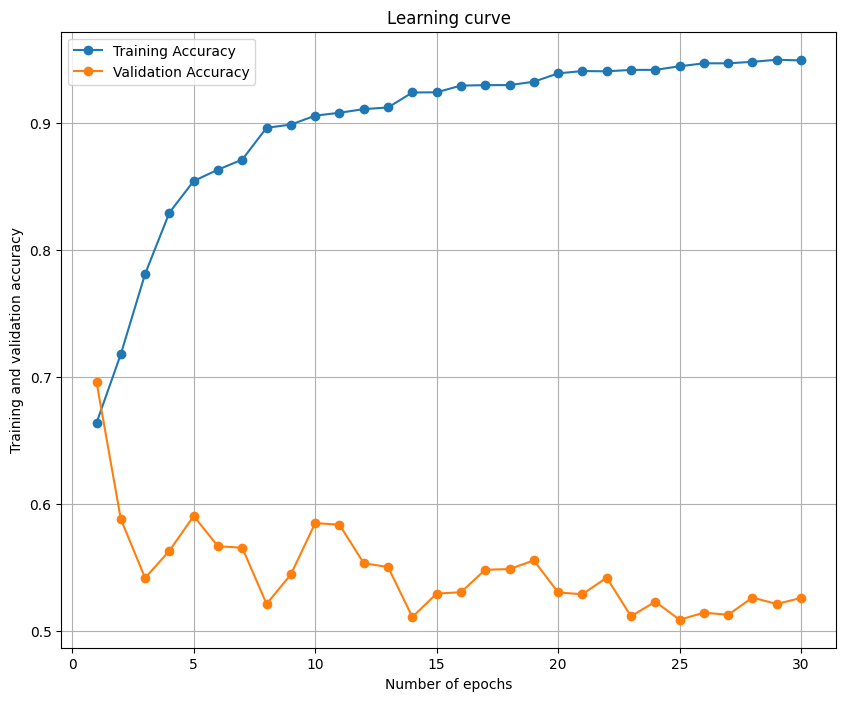

In [86]:
plot_accuracy(accu)

In [ ]:
with open("model.pickle", "wb") as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

# New Dataset

In [31]:
new_data = pd.read_csv("data/Sample_Game_3/Sample_Game_3_tracking.txt", sep=r"[;,:]", header=None, engine="python")
new_data.index =  range(1, len(new_data) + 1)

In [32]:
time = np.arange(0.04, (len(new_data) + 1) * 0.04, 0.04).round(2)
new_data.insert(1, "Time [s]", time)

In [33]:
columns = ['Frame', 'Time [s]', 'Home-Player11-x', 'Home-Player11-y', 'Home-Player1-x', 'Home-Player1-y', 'Home-Player2-x', 'Home-Player2-y',
       'Home-Player3-x', 'Home-Player3-y', 'Home-Player4-x', 'Home-Player4-y', 'Home-Player5-x', 'Home-Player5-y', 'Home-Player6-x', 'Home-Player6-y',
       'Home-Player7-x', 'Home-Player7-y', 'Home-Player8-x', 'Home-Player8-y', 'Home-Player9-x', 'Home-Player9-y', 'Home-Player10-x',
       'Home-Player10-y', 'Away-Player25-x', 'Away-Player25-y', 'Away-Player15-x', 'Away-Player15-y', 'Away-Player16-x',
       'Away-Player16-y', 'Away-Player17-x', 'Away-Player17-y', 'Away-Player18-x', 'Away-Player18-y', 'Away-Player19-x',
       'Away-Player19-y', 'Away-Player20-x', 'Away-Player20-y', 'Away-Player21-x', 'Away-Player21-y', 'Away-Player22-x',
       'Away-Player22-y', 'Away-Player23-x', 'Away-Player23-y', 'Away-Player24-x', 'Away-Player24-y', "Ball-x", "Ball-y"]

new_data.columns = columns

In [34]:
new_data #= new_data.iloc[:, :-2]

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,NaN,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,NaN,NaN
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,NaN,NaN
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,NaN,NaN
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,NaN,NaN
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,NaN,NaN
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,NaN,NaN


In [35]:
new_data = game_2_pre._fill_missing_with_interpolation_and_fill(new_data)

In [36]:
new_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485


In [37]:
vel_acc_new_data = game_1_pre.vel_acc(new_data)
vel_acc_new_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,0.0,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,0.0,0.0
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,0.0,0.0
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,0.0,0.0
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,0.0,0.0
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,0.0,0.0
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,0.0,0.0


In [38]:
new_data_ply_tra = vel_acc_new_data.iloc[:, 2:]
new_data_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,0.62405,0.80669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,0.62371,0.80594,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,0.0,NaN
3,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,0.62354,0.80601,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,0.0,0.0
4,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,0.62318,0.80604,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,0.0,0.0
5,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,0.62286,0.80626,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,0.50927,0.27457,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,0.0,0.0
143758,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,0.50913,0.27654,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,0.0,0.0
143759,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,0.50876,0.27762,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,0.0,0.0
143760,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,0.50808,0.27935,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,0.0,0.0


In [39]:
new_data_player_data = game_1_pre.get_frames(new_data_ply_tra, columns=new_data_ply_tra.columns[0:46:2]).round(3).fillna(0)
new_data_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
1,0.847,0.529,0.0,0.0,0.653,0.248,0.000,0.000,0.665,0.466,...,0.000,0.000,0.489,0.364,0.000,0.000,0.501,0.487,0.0,0.0
2,0.847,0.529,0.0,0.0,0.652,0.245,0.070,0.000,0.665,0.465,...,0.005,0.000,0.488,0.364,0.008,0.000,0.501,0.487,0.0,0.0
3,0.847,0.529,0.0,0.0,0.652,0.244,0.033,-0.943,0.665,0.465,...,0.011,0.156,0.488,0.364,0.006,-0.050,0.501,0.487,0.0,0.0
4,0.847,0.529,0.0,0.0,0.652,0.243,0.026,-0.167,0.665,0.465,...,0.014,0.086,0.488,0.363,0.024,0.462,0.501,0.487,0.0,0.0
5,0.847,0.529,0.0,0.0,0.651,0.243,0.011,-0.369,0.665,0.465,...,0.012,-0.044,0.488,0.362,0.010,-0.358,0.501,0.487,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.120,0.518,0.0,0.0,0.478,0.454,0.018,0.206,0.497,0.773,...,0.007,0.062,0.808,0.271,0.017,-0.018,0.892,0.505,0.0,0.0
143758,0.120,0.518,0.0,0.0,0.478,0.455,0.029,0.282,0.497,0.774,...,0.014,0.170,0.807,0.272,0.028,0.276,0.892,0.505,0.0,0.0
143759,0.120,0.518,0.0,0.0,0.477,0.457,0.048,0.486,0.497,0.776,...,0.022,0.199,0.806,0.272,0.036,0.191,0.892,0.505,0.0,0.0
143760,0.120,0.518,0.0,0.0,0.477,0.459,0.062,0.352,0.497,0.776,...,0.037,0.374,0.804,0.273,0.035,-0.020,0.892,0.505,0.0,0.0


In [37]:
with open("data/Sample_Game_3/Sample_Game_3_events.json", "r") as f:
    data = json.load(f)

In [38]:
type_ = np.array([])
start_frame = np.array([])
end_frame = np.array([])

for i in data["data"]:
    t = i["type"]["name"]
    sf = i["start"]["frame"]
    ef = i["end"]["frame"]

    # if t != "CARRY":   
    type_ = np.append(type_, t)
    start_frame = np.append(start_frame, sf)
    end_frame = np.append(end_frame, ef)


new_data_event_data = pd.DataFrame({"Type": type_, "Start Frame": start_frame.astype(np.int64), "End Frame": end_frame.astype(np.int64)})

In [39]:
new_data_event_data

,Type,Start Frame,End Frame
0,SET PIECE,361,361
1,PASS,361,377
2,CARRY,377,384
3,PASS,384,426
4,CARRY,426,465
...,...,...,...
3615,PASS,143406,143469
3616,PASS,143469,143532
3617,CARRY,143469,143470
3618,CARRY,143532,143553


In [43]:
new_data_event_data = fix_events(new_data_event_data)

In [46]:
start_frames = new_data_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = new_data_event_data["End Frame"].iloc[1:].to_numpy()
event_types = new_data_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = new_data_player_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
new_data_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    new_data_event.loc[s:e, "Type"] = e_t

new_data_event = new_data_event.dropna()

In [45]:
new_data_event = new_data_event[~(new_data_event["Type"] == "CARD")]
new_data_event#.drop()

,Type
362,PASS
363,PASS
364,PASS
365,PASS
366,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [ ]:
# with open("model.pickle", "rb") as f:
#     loaded_model = pickle.load(f)

In [47]:
valid_indices = new_data_event.index.intersection(new_data_player_data.index)
X_new = new_data_player_data.loc[valid_indices]
y_new = new_data_event.loc[valid_indices, "Type"]

In [ ]:
# X_new = game_1_pre.expand_dataset(dataset=X_new, look_back=50)
# y_new = game_1_pre.expand_dataset(dataset=y_new, look_back=50)

In [48]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'RECOVERY',
        'SET PIECE', 'SHOT'], dtype=object),
 array([ 9811,  2839,     4,   196, 28180,   179,    76,   606],
       dtype=int64))

In [49]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'RECOVERY',
        'SET PIECE', 'SHOT'], dtype=object),
 array([ 7470,  2424,     6,   276, 32378,   165,    79,   535],
       dtype=int64))

In [50]:
np.unique(y_new, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'RECOVERY',
        'SET PIECE', 'SHOT'], dtype=object),
 array([10873,  2612,     1,   254, 42961,   201,    89,   393],
       dtype=int64))

In [51]:
label_encoder = LabelEncoder()
y_1 = label_encoder.fit_transform(y_1)
y_new = label_encoder.transform(y_new)
y_2 = label_encoder.transform(y_2)

In [52]:
scaler = StandardScaler()
X_1 = scaler.fit_transform(X_1)
X_2 = scaler.transform(X_2)
X_new = scaler.transform(X_new)

In [89]:
print(X_1.shape)
print(X_2.shape)
# print(X_new.shape)

(41850, 46)
(43300, 46)


In [88]:
# TEMP SOLUTIONS
X_1 = X_1[:41850]
y_1 = y_1[:41850]

X_2 = X_2[:43300]
y_2 = y_2[:43300]

# X_new = X_new[:57350]
# y_new = y_new[:57350]

In [86]:
print(X_1.shape)
print(X_2.shape)
print(X_new.shape)

(41850, 92)
(43300, 92)
(57350, 92)


In [87]:
np.unique(y_new, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([10872,  2612,     1,   254, 42928,   201,    89,   393],
       dtype=int64))

In [88]:
assert X_new.shape[0] == y_new.shape[0]

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [91]:
np.unique(y_1).shape, np.unique(y_2).shape, np.unique(y_new).shape

NameError: name 'y_new' is not defined

In [108]:
# assert X_1.shape[1] == X_2.shape[1] == X_new.shape[1]
# assert np.unique(y_1).shape == np.unique(y_2).shape == np.unique(y_new).shape

input_size = X_1.shape[1]
hidden_size = 256
num_layers = 2
num_classes = np.unique(y_1).shape[0]
sequence_length = 25
learning_rate = 0.001
batch_size = 256
num_epochs = 50

In [109]:
class CustomDataset(Dataset):
    def __init__(self, features, labels, sequence_task=True):
        self.features = torch.tensor(features.values if hasattr(features, "values") else features,
                                   dtype=torch.float32)
        self.labels = torch.tensor(labels.values if hasattr(labels, "values") else labels,
                                 dtype=torch.long)
        self.sequence_task = sequence_task
        
        # Validate shapes
        assert self.features.shape[0] == self.labels.shape[0], \
            f"Number of samples mismatch: features {self.features.shape[0]}, labels {self.labels.shape[0]}"
        
        if sequence_task:
            assert self.features.shape[1] == self.labels.shape[1], \
                f"Sequence length mismatch: features {self.features.shape[1]}, labels {self.labels.shape[1]}"
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Reshape the NumPy array
X_1_reshaped = X_1.reshape(-1, sequence_length, input_size)
y_1_reshaped = y_1.reshape(-1, sequence_length)

X_2_reshaped = X_2.reshape(-1, sequence_length, input_size)
y_2_reshaped = y_2.reshape(-1, sequence_length) 

# X_new_reshaped = X_new.reshape(-1, sequence_length, input_size)
# y_new_reshaped = y_new.reshape(-1, sequence_length) 

# Create DataLoaders
training_dataset = CustomDataset(X_1_reshaped, y_1_reshaped)
validation_dataset = CustomDataset(X_2_reshaped, y_2_reshaped)
# testing_dataset = CustomDataset(X_new_reshaped, y_new_reshaped)

train_loader = DataLoader(
    dataset=training_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

validation_loader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

# test_loader = DataLoader(
#     dataset=testing_dataset, 
#     batch_size=batch_size, 
#     shuffle=False,
# )

In [110]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.init_weights()

    def init_weights(self):
        # Initialize LSTM weights
        for name, param in self.lstm.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
       
        nn.init.xavier_uniform_(self.fc.weight)

        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)
                    
    def forward(self, x):
        batch_size = x.size(0)
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        reshaped_out = lstm_out.contiguous().view(-1, self.hidden_size)
       
        out = self.fc(reshaped_out)
        
        out = out.view(batch_size, -1, out.size(-1))
        
        return out

In [111]:
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)
model

LSTM(
  (lstm): LSTM(46, 256, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=256, out_features=8, bias=True)
)

In [112]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

accu = {"training_accuracy": [], "validation_accuracy": [], "testing_accuracy": []}

train_dataset_len = len(train_loader.dataset)
val_dataset_len = len(validation_loader.dataset)

for epoch in range(num_epochs):
    train_acc = 0
    train_loss = 0
    
    val_acc = 0
    val_loss = 0
    
    model.train()
    
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
                
        outputs = model(data)
        outputs = outputs.permute(0, 2, 1)
        
        loss = criterion(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        _, pred = torch.max(outputs, 1)
        train_acc += (pred == label).float().sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_acc / (train_dataset_len * sequence_length)
    accu["training_accuracy"].append(train_accuracy)

    model.eval()
    with torch.no_grad():
        for data, label in validation_loader:
            data, label = data.to(device), label.to(device)
        
            outputs = model(data)
            outputs = outputs.permute(0, 2, 1)
            
            loss = criterion(outputs, label)
            val_loss += loss.item()
            
            _, pred = torch.max(outputs, 1)
            val_acc += (pred == label).float().sum().item()

    val_loss /= len(validation_loader)
    val_accuracy = val_acc / (val_dataset_len * sequence_length)
    accu["validation_accuracy"].append(val_accuracy)
    
    l_rate = optimizer.param_groups[0]["lr"]
    # scheduler.step(train_loss)    
    
    print(f"Epoch[{epoch + 1}] | "
          f"training accuracy: {train_accuracy * 100:0.2f}% | "
          f"validation accuracy: {val_accuracy * 100:0.2f}% | "
          f"train loss: {train_loss:.4f} | "
          f"val loss: {val_loss:.4f} | "
          f"learning rate: {l_rate:.4f}")

Epoch[1] | training accuracy: 61.04% | validation accuracy: 74.78% | train loss: 1.4110 | val loss: 0.9124 | learning rate: 0.0010
Epoch[2] | training accuracy: 57.11% | validation accuracy: 74.78% | train loss: 1.0583 | val loss: 0.8657 | learning rate: 0.0010
Epoch[3] | training accuracy: 67.31% | validation accuracy: 74.78% | train loss: 0.9923 | val loss: 0.8513 | learning rate: 0.0010
Epoch[4] | training accuracy: 67.31% | validation accuracy: 74.78% | train loss: 0.9536 | val loss: 0.8609 | learning rate: 0.0010
Epoch[5] | training accuracy: 67.31% | validation accuracy: 74.78% | train loss: 0.9295 | val loss: 0.8275 | learning rate: 0.0010
Epoch[6] | training accuracy: 67.31% | validation accuracy: 74.78% | train loss: 0.9313 | val loss: 0.8319 | learning rate: 0.0010
Epoch[7] | training accuracy: 67.31% | validation accuracy: 74.78% | train loss: 0.9213 | val loss: 0.8255 | learning rate: 0.0010
Epoch[8] | training accuracy: 67.31% | validation accuracy: 74.78% | train loss: 0.

In [107]:
test_acc = 0
test_loss = 0
test_dataset_len = len(test_loader.dataset)

model.eval()

with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        
        outputs = model(data)
        outputs = outputs.permute(0, 2, 1)

        test_loss += criterion(outputs, label).item()
        
        _, pred = torch.max(outputs, 1)
        test_acc += (pred == label).float().sum().item()

    test_loss /= len(test_loader)
    test_accuracy = test_acc / (test_dataset_len * sequence_length)
    accu["testing_accuracy"].append(test_accuracy)

print(f"Accuracy on test set: {test_accuracy * 100:.2f}%")

NameError: name 'test_loader' is not defined

In [ ]:
def plot_accuracy(accuracy):    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(list(range(1, num_epochs + 1)), accuracy["training_accuracy"], marker="o", label="Training Accuracy")
    ax.plot(list(range(1, num_epochs + 1)), accuracy["validation_accuracy"], marker="o", label="Validation Accuracy")
    # ax.plot(list(range(1, 2)), accuracy["testing_accuracy"], marker="o", label="Testing Accuracy")

    ax.set_xlabel("Number of epochs")
    ax.set_ylabel("Training and validation accuracy")
    ax.set_title("Learning curve")
    
    ax.grid(True)
    ax.legend()
    
    plt.show()

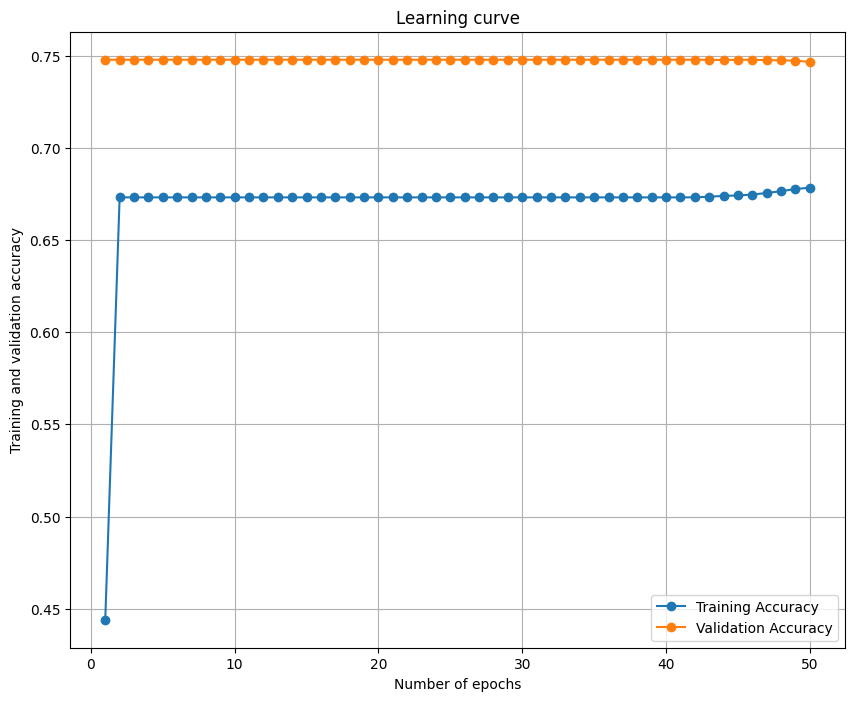

In [106]:
plot_accuracy(accu)